<a href="https://colab.research.google.com/github/Fame2875/TwitterSentimentAnalysis/blob/main/Twitter_Sentiment_Analysis_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

67016018 ชนสรณ์ จึงมาริศกุล

Dataset จาก :https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data

Target คือ การวิเคราะห์ข้อความบนทวิตเตอร์ว่าเป็นข้อความเชิงลบ กลางหรือบวกหรือไม่เกี่ยวข้อง โดยการใช้โมเดล  Sequential Model ด้วยการใช้ Recurrent Neural Networks (RNN)



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
import spacy

<h1>Reading The Data</h1>

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/twitter_training.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/twitter_validation.csv')


# Data Preprocessing - analysis

In [3]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


ข้อมูลไม่มี Header คอยกำกับ จึงจะทำการ Add header กำหนดเองเข้าไป

In [5]:
df_test.columns = ['Header1', 'company','sentiment','text']
df_train.columns = ['Header1', 'company','sentiment','text']

In [6]:
df_train.head()

,Header1,company,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [7]:
df_train.shape

(74681, 4)

In [8]:
df_test.shape

(999, 4)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Header1    74681 non-null  int64 
 1   company    74681 non-null  object
 2   sentiment  74681 non-null  object
 3   text       73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Header1    999 non-null    int64 
 1   company    999 non-null    object
 2   sentiment  999 non-null    object
 3   text       999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [11]:
unique_sentiments = df_test['sentiment'].unique()
print(unique_sentiments)

['Neutral' 'Negative' 'Positive' 'Irrelevant']


In [12]:
unique_sentiments2 = df_train['sentiment'].unique()
print(unique_sentiments)

['Neutral' 'Negative' 'Positive' 'Irrelevant']


In [13]:
df_train.duplicated().sum()

2700

In [15]:
df_test.duplicated().sum()

0

In [14]:
df_train.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,686


In [16]:
df_test.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,0


Insight:<br>
Dataset Train  มี 74681 rows และ 4 columns<br>
Dataset Train มี NULL values ที่ Text อยู่ทั้งหมด 686 rows<br>
Dataset Train มี duplicates rows อยู่ที่ 2700 rows

Dataset Test  มี 999 rows และ 4 columns<br>
Dataset Test ไม่มี NULL value<br>
Dataset Test ไม่มี duplicates rows

เนื่องจากต้องการจะวิเคราะห์แค่ข้อความว่าเป็นด้านใด ทำให้ Header1 และ company ไม่จำเป็นต้องนำมาวิเคราะห์ สามารถ Drop ได้

# Data Preprocessing - Clean Data

<h2>ทำการดรอปข้อมูลที่ค่า Text เป็น 0 ออกเนื่องจากขาดมีข้อมูลที่สำคัญในการวิเคราะห์</h2>

In [17]:
df_train.dropna(inplace=True)

In [18]:
df_train.isnull().sum()

,0
Header1,0
company,0
sentiment,0
text,0


<h2>ทำการดรอปข้อมูลที่ duplicates</h2>

In [19]:
df_train.drop_duplicates(inplace=True)

In [20]:
df_train.duplicated().sum()

0

<h2>ทำการดรอป column </h2>

In [21]:
df_train.drop(columns=['Header1', 'company'], inplace=True)

In [22]:
df_test.drop(columns=['Header1', 'company'], inplace=True)

In [23]:
df_train

,sentiment,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [24]:
df_test

,sentiment,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


# Preprocessing the Data

**<h3>Lowercasing</h3>**

เปลี่ยนทุกตัวอักษรให้เป็น lower case เพื่อที่จะตัดปัญหา case-sensitive ออกไป

In [25]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

**<h3>Remove html tags,URLs, special characters,punctuations using Regular expressions</h3>**

In [26]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [27]:
# Clean the training data
df_train['text'] = df_train['text'].apply(clean_tweet)

In [28]:
# Clean the test data
df_test['text'] = df_test['text'].apply(clean_tweet)

In [29]:
df_train.head()

,sentiment,text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [30]:
df_test.head()

,sentiment,text
0,Neutral,bbc news amazon boss jeff bezos rejects claims...
1,Negative,why do i pay for word when it functions so poo...
2,Negative,csgo matchmaking is so full of closet hacking ...
3,Neutral,now the president is slapping americans in the...
4,Negative,hi i ve had madeleine mccann in my cellar for ...


In [31]:
df_train.duplicated().sum()

4973

<h2>เมื่อ Clean ข้อมูลเรียบร้อยแล้วพบว่ามีข้อมูล Duplicated เพิ่มจึงต้องทำการลบออกอีกที</h2>

In [32]:
df_train = df_train.drop_duplicates(subset=['text'])

<h2>Remove Emojis

In [33]:
# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # miscellaneous symbols
                                u"\U00002FC2-\U0001F251"  # additional symbols
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply the emoji removal to 'text' column of both training and test datasets
df_train['text'] = df_train['text'].apply(remove_emoji)
df_test['text'] = df_test['text'].apply(remove_emoji)

# Show the first few rows to verify the emoji removal
print(df_train[['text']].head())
print(df_test[['text']].head())


                                                text
0  i am coming to the borders and i will kill you...
1  im getting on borderlands and i will kill you all
2  im coming on borderlands and i will murder you...
3  im getting on borderlands and i will murder yo...
4  im getting into borderlands and i can murder y...
                                                text
0  bbc news amazon boss jeff bezos rejects claims...
1  why do i pay for word when it functions so poo...
2  csgo matchmaking is so full of closet hacking ...
3  now the president is slapping americans in the...
4  hi i ve had madeleine mccann in my cellar for ...


<ipython-input-33-bb780fddaed5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].apply(remove_emoji)


In [34]:
import re
import nltk
from nltk.corpus import stopwords

In [35]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')

# Get stopwords list
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [36]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [37]:
# Apply stopwords removal
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

# Show the first few rows to verify the cleaning process
print(df_train[['text']].head())
print(df_test[['text']].head())

                            text
0            coming borders kill
1    im getting borderlands kill
2   im coming borderlands murder
3  im getting borderlands murder
4  im getting borderlands murder
                                                text
0  bbc news amazon boss jeff bezos rejects claims...
1               pay word functions poorly chromebook
2  csgo matchmaking full closet hacking truly awf...
3  president slapping americans face really commi...
4  hi madeleine mccann cellar past years little s...


<ipython-input-37-5110ab203e00>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train['text'].apply(remove_stopwords)


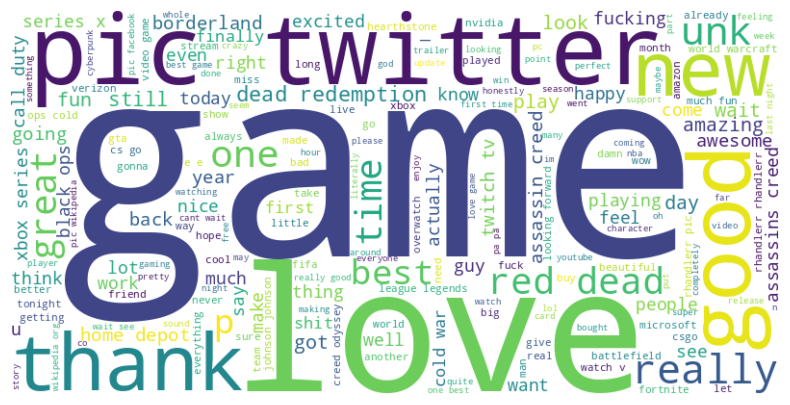

In [38]:
from wordcloud import WordCloud
# Corrected code for creating the word cloud
word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Positive"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(word_cloud_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h3>Word Cloud แสดงความรู้สึกเชิงบวก:</h3>


*   คำที่ชัดเจนที่สุด ได้แก่ "game" "love" "thank" "best" และ "amazing" ซึ่งสะท้อนว่าผู้คนมักแสดงความรู้สึกเชิงบวกเมื่อพูดถึงสิ่งที่พวกเขาชื่นชอบหรือซาบซึ้ง เช่น เกมหรือประสบการณ์ต่าง ๆ
*   คำอย่าง "thank" "love" และ "best" แสดงถึงความรู้สึกขอบคุณและชื่นชม ในขณะเดียวกันคำที่เกี่ยวข้องกับการเล่นเกม เช่น "game" "play" และ "fun" มีการใช้อย่างแพร่หลายซึ่งชี้ให้เห็นว่าการเล่นเกมเป็นหัวข้อที่ได้รับความนิยมในข้อความที่มีความรู้สึกเชิงบวก






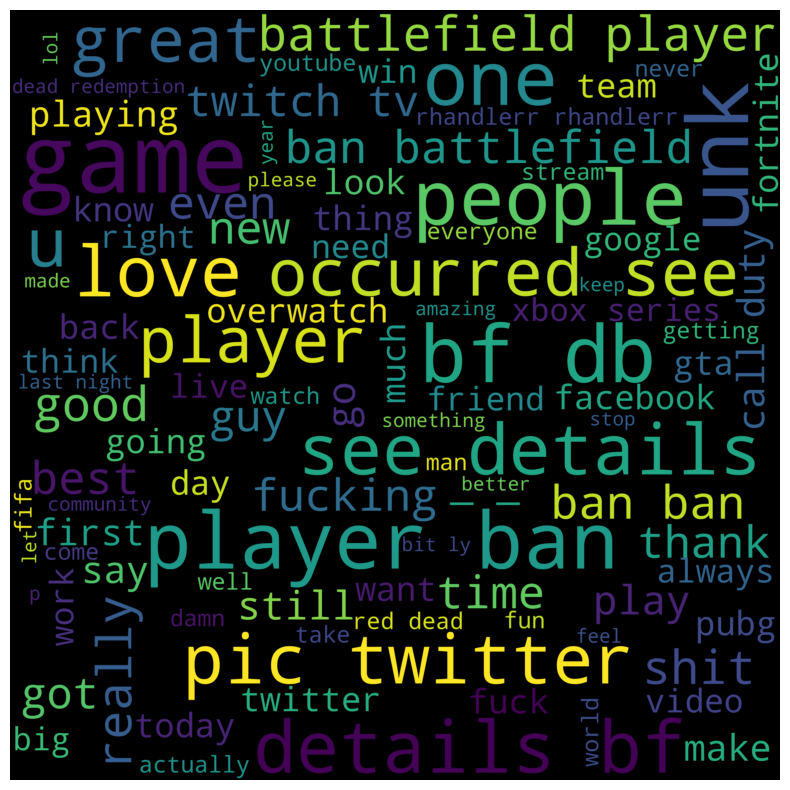

In [39]:

word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Irrelevant"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Word Cloud แสดงความรู้สึกเชิงลบ:


*   ใน word cloud ของข้อความเชิงลบพบคำเช่น "game" "player" "ban" "details" และ "team" อยู่บ่อยครั้ง นอกจากนี้ยังปรากฏคำที่มีลักษณะหยาบคายหรือเชิงลบ (เช่น "fucking" หรือ "shit") ซึ่งอาจสะท้อนลักษณะของบทสนทนาที่ไม่สร้างสรรค์หรือไม่มีประโยชน์

*   แม้กลุ่มนี้จะพบคำว่า "game" เช่นกันแต่การปรากฏของคำอย่าง "ban" และ "player" รวมถึงคำหยาบคายแสดงว่าข้อความเหล่านี้อาจเกี่ยวข้องกับการวิจารณ์หรือการสนทนาเชิงลบ เช่น การร้องเรียน หรือบทสนทนาที่ไม่สร้างสรรค์เกี่ยวกับเกม การแบนหรือพฤติกรรมในเกม เป็นต้น



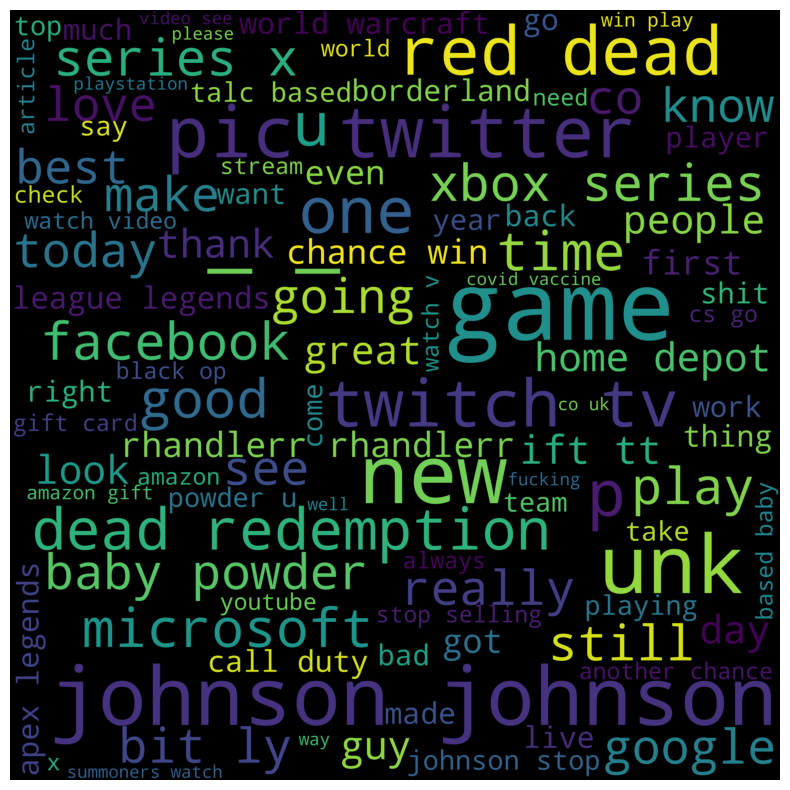

In [40]:
# Corrected code for creating the word cloud for "Neutral" type
word_cloud_text = ' '.join(df_train[df_train["sentiment"] == "Neutral"]["text"].str.lower())
# Creation of word cloud
wordcloud = WordCloud(
    max_font_size=100,
    max_words=100,
    background_color="black",
    scale=10,
    width=800,
    height=800
).generate(word_cloud_text)
# Figure properties
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()



*   คำว่า "game" เป็นคำที่เด่นที่สุด ซึ่งอาจบ่งบอกถึงความถี่ในการพูดคุยเกี่ยวกับเกม
*   คำสำคัญอื่นๆ เช่น "johnson", "twitch", "facebook", "google", และ "red dead" บ่งบอกถึงการสนทนาเกี่ยวกับแพลตฟอร์ม บุคคล หรือหัวข้อที่เป็นที่นิยมในชุดข้อมูล ซึ่งสอดคล้องกับความเป็นข้อความที่มีอารมณ์เป็นกลาง
*   นอกจากคำว่า "game" แล้วยังมีคำอย่าง "red dead", "xbox", "microsoft", และ "play" ซึ่งบ่งบอกถึงการสนทนาเกี่ยวกับเครื่องเล่นเกมและเกมที่เฉพาะเจาะจง เช่น Red Dead Redemption
*   คำที่มีอารมณ์เป็นกลางอื่นๆ เช่น "people", "day", "love", และ "time" ชี้ให้เห็นว่าชุดข้อมูลอาจประกอบด้วยการสนทนาในชีวิตประจำวันหรือหัวข้อทั่วไป ไม่จำกัดแค่เรื่องเกมเท่านั้น






<h2>Split the Data</h2>

In [38]:
# Separate features and labels for training data
train_texts = df_train['text'].values
train_labels = df_train['sentiment'].values

# Separate features and labels for test data
test_texts = df_test['text'].values
test_labels = df_test['sentiment'].values

In [39]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label mapping:", label_mapping)

Label mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [40]:
# Initialize the tokenizer
tokenizer = Tokenizer()  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [41]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [42]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 163


In [43]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [44]:
# Embedding Input Size
input_size = np.max(train_padded) + 1
input_size

29255

Dataset Preparation:


*   ใช้ LabelEncoder ในการเข้ารหัสป้ายกำกับเป็นตัวเลขเพื่อให้ง่ายต่อการประมวลผล

*   ใช้ Tokenizer ในการแปลงข้อความเป็นลำดับของโทเค็น ซึ่งจะถูกปรับขนาดด้วย pad_sequences ให้มีความยาวเท่ากัน (maxlen) เพื่อให้สอดคล้องกัน
*   ข้อมูลข้อความถูกแบ่งออกเป็นชุดข้อมูลสำหรับการฝึกและการทดสอบ (df_train และ df_test)






# Modeling

In [49]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import pickle
import tensorflow as tf
# Define the model
model = Sequential()

# Add an embedding layer with dropout
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(56,)))
model.add(Dropout(0.3))  # Dropout after embedding

# First LSTM layer with increased regularization and dropout
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increased dropout

# Second LSTM layer with increased regularization and dropout
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.4))  # Increased dropout

# Dense layer with batch normalization
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))  # Increased dropout

# Output layer
model.add(Dense(5, activation='softmax'))

# Model summary
model.summary()

# Compile the model with gradient clipping
optimizer = Adam(clipnorm=1.0)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint('best_sentiment_model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Train the model with the learning rate scheduler and checkpointing
history = model.fit(
    train_padded,
    train_labels_encoded,
    validation_data=(test_padded, test_labels_encoded),
    epochs=50,
    callbacks=[lr_scheduler, checkpoint]
)

# Save the final model
model.save('my_sentiment_model.keras')

# Download the model files to local machine (if using Colab)
from google.colab import files
files.download('my_sentiment_model.keras')
files.download('best_sentiment_model.keras')

# Save the tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the label encoder
with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Download the tokenizer and label encoder (if using Colab)
files.download('tokenizer.pickle')
files.download('label_encoder.pickle')

# To load the best model for later use
best_model = tf.keras.models.load_model('best_sentiment_model.keras')

# Load the tokenizer for later use
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load the label encoder for later use
with open('label_encoder.pickle', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 56, 100)             │       2,925,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 56, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 56, 128)             │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 56, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 56, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,118,657 (11.90 MB)

 Trainable params: 3,118,017 (11.89 MB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4288 - loss: 4.2989
Epoch 1: val_loss improved from inf to 0.54822, saving model to best_sentiment_model.keras
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 72s 32ms/step - accuracy: 0.4288 - loss: 4.2978 - val_accuracy: 0.8278 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 2/50
2074/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8061 - loss: 0.6298
Epoch 2: val_loss improved from 0.54822 to 0.36917, saving model to best_sentiment_model.keras
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 66s 32ms/step - accuracy: 0.8061 - loss: 0.6298 - val_accuracy: 0.9089 - val_loss: 0.3692 - learning_rate: 0.0010
Epoch 3/50
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8686 - loss: 0.4629
Epoch 3: val_loss did not improve from 0.36917
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 65s 32ms/step - accuracy: 0.8686 - loss: 0.4629 - val_accuracy: 0.8579 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 4/50
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9590 - loss: 0.1635
Test Loss: 0.168266162276268
Test Accuracy: 0.9619619846343994


mbedding Layer: แปลงคำหรือข้อความ ให้เป็นเวกเตอร์ในมิติ 100 มิติ เพื่อให้โมเดลเข้าใจข้อมูลได้ดีขึ้น

Dropout(0.3): เทคนิคที่ใช้ลดการเกิด Overfitting โดยสุ่มปิดการทำงานของ 30% ของหน่วยระหว่างการฝึก

Bidirectional LSTM Layers:

*   Bidirectional LSTM (64 units): ทำการประมวลผลข้อมูลจากทั้งสองทิศทาง (ไปข้างหน้าและย้อนหลัง) เพื่อให้โมเดลเข้าใจบริบทของข้อความได้ดีขึ้น

*   ใช้ L2 Regularization เพื่อป้องกัน Overfitting โดยลดค่าพารามิเตอร์ที่มีค่าสูง
*   BatchNormalization: ปรับค่าของเอาต์พุตให้มีความเสถียรมากขึ้น

Dense Layer:



*   Dense(64 units): ใช้สำหรับรวมข้อมูลจาก LSTM ให้แน่นขึ้น พร้อมการใช้ ReLU เป็นฟังก์ชัน Activation เพื่อให้เป็น  non-linearity





Training Strategy:
  Loss Function:

*   ใช้ sparse_categorical_crossentropy สำหรับปัญหาการจัดหมวดหมู่หลายคลาส โดยที่เลเบลเป็นจำนวนเต็ม

Optimizer:


*   ใช้ Adam พร้อมกับ gradient clipping เพื่อป้องกันปัญหากราฟของค่า gradient เกิดการเปลี่ยนแปลงอย่างรวดเร็ว

Learning Rate Scheduler:


*   ใช้ ReduceLROnPlateau เพื่อลดอัตราการเรียนรู้เมื่อค่าความสูญเสียไม่ลดลงหลังจากการฝึกหลายรอบ









Evaluate the mode

In [52]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_padded, test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9590 - loss: 0.1635
Test Loss: 0.168266162276268
Test Accuracy: 0.9619619846343994


Visualize training history

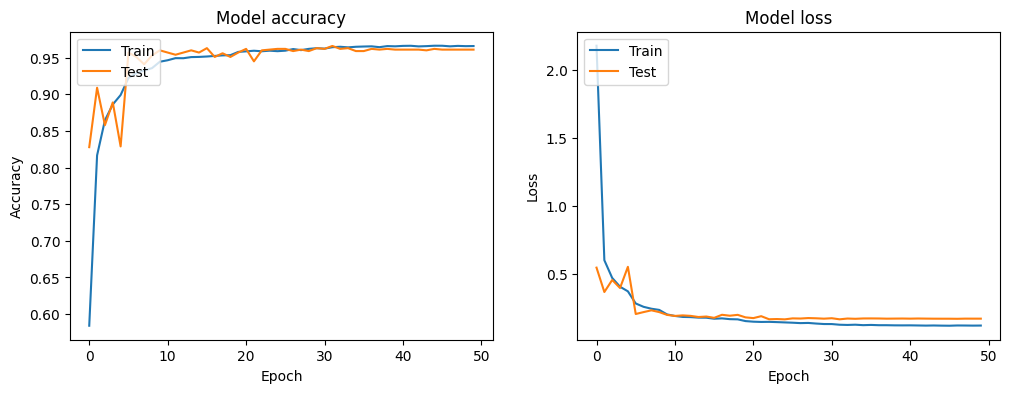

In [53]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Accuracy and Loss Graphs :



*  Accuracy ในการฝึก (เส้นสีน้ำเงิน): เริ่มต้นจากค่าต่ำ แต่เพิ่มขึ้นอย่างรวดเร็วและคงที่ที่ประมาณ 0.95 หลังจากการเทรนประมาณ 10 รอบ (epochs)

*   Accuracy ของชุดทดสอบ (เส้นสีส้ม): (เส้นสีส้ม) มีแนวโน้มเหมือนกับการเทรน และมีค่าคงที่ใกล้เคียงกันที่ประมาณ 0.95
*   ค่าความแม่นยำที่ใกล้เคียงกันระหว่างชุดข้อมูลการเทรนและทดสอบนี้ บ่งบอกว่าโมเดลไม่ได้เกิดการ overfitting และมีความสามารถในการทำนายข้อมูลใหม่ได้ดี




*   Model loss ในการฝึก (เส้นสีน้ำเงิน): เริ่มต้นที่ค่าสูง (ประมาณ 2.0) แต่ลดลงอย่างรวดเร็วและคงที่หลังจากประมาณ 10 epochs โดยมีค่าการสูญเสียต่ำมาก (ใกล้ 0)
*   Model loss ในการเทรน:  มีแนวโน้มลดลงคล้ายกับชุดเทรน แต่มีค่าการสูญเสียสูงกว่านิดหน่อย


*   ความแตกต่างของค่าการสูญเสียระหว่างชุดเทรนและทดสอบไม่มาก แสดงว่าโมเดลมีการ generalize ได้ดี คือสามารถใช้งานกับข้อมูลที่ไม่เคยเห็นได้ดี




32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


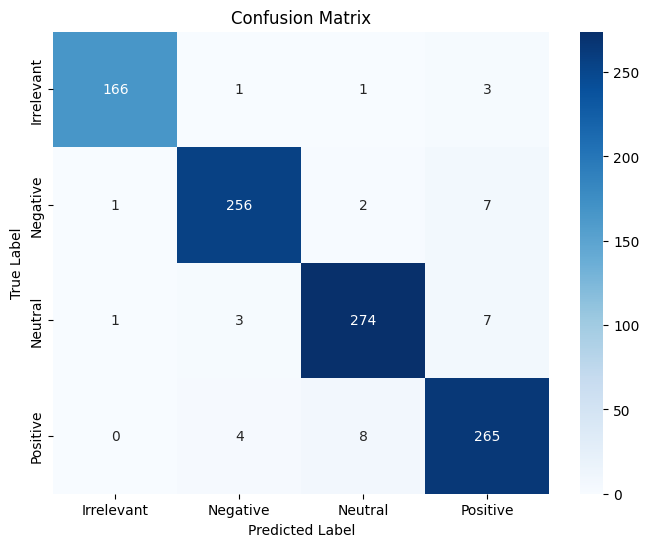

In [55]:
# Generate predictions and plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Step 1: Predict the labels for the test set
y_pred = best_model.predict(test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Step 2: Get the true labels (already encoded in test_labels_encoded)
y_true = test_labels_encoded

# Step 3: Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Label mapping: {'Irrelevant': class 0, 'Negative': class 1, 'Neutral': class 2, 'Positive': class 3}

ส่วนใหญ่จะเห็นได้ว่ามีการทำนายผิดน้อย โดยคลาสที่ทำนายผิดบ่อยที่สุดคือการทำนายผิดจากคลาส "Neutral" ไปเป็น "Positive" ซึ่งอาจเกิดจากความคล้ายคลึงของข้อมูลในสองคลาสนี้confusion matrix :


*   ค่าบนเส้นทแยงมุมของ Matrix สูงสำหรับทุก Class ซึ่งแปลว่าโมเดลทำนายถูกต้องเป็นส่วนใหญ่


*   มีการทำนายผิดเพียงเล็กน้อยและไม่บ่อย ซึ่งหมายความว่าโมเดลมีความแม่นยำสูง แต่ยังมีการสับสนระหว่าง Class ที่อยู่ติดกัน เช่น Class 1 บางครั้งถูกทำนายเป็น Class 0 หรือ Class 2
*   ส่วนใหญ่จะเห็นได้ว่ามีการทำนายผิดน้อย โดยคลาสที่ทำนายผิดบ่อยที่สุดคือการทำนายผิดจากคลาส "Neutral" ไปเป็น "Positive" ซึ่งอาจเกิดจากความคล้ายคลึงของข้อมูลในสองคลาสนี้


*   ความสมดุลของ Class: จำนวนการทำนายที่ถูกต้องกระจายไปอย่างดีในทุก Class แสดงว่าโมเดลไม่มีความเอนเอียงไปยัง Class ใดเป็นพิเศษ




Test model

ทำการทดลองใช้โมเดลที่เทรนมาแล้ว

In [68]:
df = pd.read_csv("https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/custom_data2.csv")

In [69]:
df.columns = ['Header1', 'company_gamename','sentiment','text']

In [70]:
df

,Header1,company_gamename,sentiment,text
0,4038,CS-GO,Negative,Finally played Rainbow Six Siege for the first...
1,526,ApexLegends,Neutral,Umm @PlayApex when I died it said Bug This pi...
2,8977,Nvidia,Neutral,"#gtc20 - nice, motivational, and very accessi..."
3,11995,Verizon,Negative,Yo! @Verizon just added a $120 'fee' to my acc...
4,9449,Overwatch,Irrelevant,They might not be the last team that has to ma...
5,10193,PlayerUnknownsBattlegrounds(PUBG),Irrelevant,Best squad yet#pubg #pubgmobile #pubgkenya ins...
6,2419,Borderlands,Negative,@Borderlands how do I submit a complaint? Your...
7,8857,Nvidia,Positive,Watching NVIDIA position itself as not just a ...
8,9704,PlayStation5(PS5),Positive,I don’t see how this looks like as Xbox contro...
9,7024,johnson&johnson,Negative,"Johnson & Johnson, knowingly sold baby powder ..."


In [71]:
df.duplicated().sum()

0

In [72]:
df.isnull().sum()

,0
Header1,0
company_gamename,0
sentiment,0
text,0


In [73]:
df.drop_duplicates(inplace=True)

In [74]:
df.duplicated().sum()

0

In [75]:
df.dropna(inplace=True)

In [76]:
df.isnull().sum()

,0
Header1,0
company_gamename,0
sentiment,0
text,0


In [77]:
df.drop(columns=['Header1', 'company_gamename'], inplace=True)

In [78]:
df

,sentiment,text
0,Negative,Finally played Rainbow Six Siege for the first...
1,Neutral,Umm @PlayApex when I died it said Bug This pi...
2,Neutral,"#gtc20 - nice, motivational, and very accessi..."
3,Negative,Yo! @Verizon just added a $120 'fee' to my acc...
4,Irrelevant,They might not be the last team that has to ma...
5,Irrelevant,Best squad yet#pubg #pubgmobile #pubgkenya ins...
6,Negative,@Borderlands how do I submit a complaint? Your...
7,Positive,Watching NVIDIA position itself as not just a ...
8,Positive,I don’t see how this looks like as Xbox contro...
9,Negative,"Johnson & Johnson, knowingly sold baby powder ..."


Preprocessing the Data

In [79]:
df['text'] = df['text'].str.lower()

In [80]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [81]:
df['text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
50 non-null     object
dtypes: object(1)
memory usage: 528.0+ bytes


In [82]:
# Clean the training data
df['text'] = df['text'].apply(clean_tweet)

In [83]:
# Function to remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"  # miscellaneous symbols
                                u"\U00002FC2-\U0001F251"  # additional symbols
                                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Apply the emoji removal to 'text' column of both training and test datasets
df['text'] = df['text'].apply(remove_emoji)


# Show the first few rows to verify the emoji removal
print(df[['text']].head())

                                                text
0  finally played rainbow six siege for the first...
1  umm when i died it said bug this pic twitter c...
2  gtc nice motivational and very accessible nvid...
3  yo just added a fee to my account under covid ...
4  they might not be the last team that has to ma...


In [84]:
df.duplicated().sum()

2

In [85]:
df = df.drop_duplicates(subset=['text'])

In [86]:
import re
import nltk
from nltk.corpus import stopwords

In [87]:
# Download NLTK stopwords if you haven't already
nltk.download('stopwords')

# Get stopwords list
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()  # Tokenize the text
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
  # Apply stopwords removal
df['text'] = df['text'].apply(remove_stopwords)

# Show the first few rows to verify the cleaning process
print(df[['text']].head())

                                                text
0  bbc news amazon boss jeff bezos rejects claims...
1               pay word functions poorly chromebook
2  csgo matchmaking full closet hacking truly awf...
3  president slapping americans face really commi...
4  hi madeleine mccann cellar past years little s...


<ipython-input-54-b66fc363bc31>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(remove_stopwords)


In [88]:
texts = df['text'].values
labels = df['sentiment'].values

In [89]:
# Initialize the label encoder
label_encoder = LabelEncoder()

In [90]:
# Fit and transform the labels
labels_encoded = label_encoder.fit_transform(labels)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label mapping:", label_mapping)

Label mapping: {'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}


In [91]:
# Initialize the tokenizer
tokenizer = Tokenizer()  # You can adjust the number of words

In [92]:
# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(texts)

In [93]:
# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(texts)

In [94]:
# Maximum Length in X_sequences
maxlen = max(len(tokens) for tokens in sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 59


In [95]:
padded = pad_sequences(sequences, maxlen=maxlen, padding='post')

In [96]:
print(padded)

[[153 154 155 ...   0   0   0]
 [166 102   1 ...   0   0   0]
 [105 169 170 ...   0   0   0]
 ...
 [  1  42  54 ...   0   0   0]
 [ 23  59   2 ...   0   0   0]
 [ 15  59   2 ...   0   0   0]]


In [97]:
# Embedding Input Size
input_size = np.max(padded) + 1
input_size

497

In [98]:
import requests
import pickle
import tensorflow as tf
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Step 1: Download files from GitHub (raw links)

# Download the model
model_url = 'https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/best_sentiment_model.keras'
model_file = 'best_sentiment_model.keras'
r = requests.get(model_url, allow_redirects=True)
open(model_file, 'wb').write(r.content)

# Download the tokenizer
tokenizer_url = 'https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/tokenizer.pickle'
tokenizer_file = 'tokenizer.pickle'
r = requests.get(tokenizer_url, allow_redirects=True)
open(tokenizer_file, 'wb').write(r.content)

# Download the label encoder
label_encoder_url = 'https://raw.githubusercontent.com/Fame2875/TwitterSentimentAnalysis/main/label_encoder.pickle'
label_encoder_file = 'label_encoder.pickle'
r = requests.get(label_encoder_url, allow_redirects=True)
open(label_encoder_file, 'wb').write(r.content)

# Step 2: Load the model, tokenizer, and label encoder
model = tf.keras.models.load_model(model_file)

with open(tokenizer_file, 'rb') as handle:
    tokenizer = pickle.load(handle)

with open(label_encoder_file, 'rb') as handle:
    label_encoder = pickle.load(handle)

# Step 3: Preprocess unseen data
unseen_texts = list(df['text'])
true_labels = df['sentiment'].values  # Actual sentiments of unseen data

# Tokenize unseen data using the same tokenizer
unseen_sequences = tokenizer.texts_to_sequences(unseen_texts)

# Pad the sequences to the same maxlen as used during training (e.g., 56)
unseen_padded = pad_sequences(unseen_sequences, maxlen=163, padding='post')

# Encode the true labels for comparison
true_labels_encoded = label_encoder.transform(true_labels)

# Step 4: Predict sentiment for the unseen data
predictions = model.predict(unseen_padded)

# Step 5: Decode the predicted classes into labels
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Step 6: Calculate accuracy
accuracy = accuracy_score(true_labels_encoded, predicted_classes)
print(f'Accuracy on unseen data: {accuracy * 100:.2f}%')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step
Accuracy on unseen data: 93.75%


สำหรับโมเดลที่นำมาใช้กับดาต้าอีกชุด ได้ผลลัพธ์ความแม่นยำอยู่ที่ 93.75 เปอร์เซ็นซึ่งถือว่าอยู่ในขั้นดี